<a href="https://colab.research.google.com/github/petyaslavkova/Bachelorarbeit/blob/main/SimpsonsFacesTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Enironment Setup

In [ ]:
import os
# !pip3 install -q fastai 
from pathlib import Path
from fastai import *
import glob
from fastai.vision import *
import argparse
import numpy as np
import PIL.Image
import PIL
import random
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
# !pip3 install -q imageio
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from distutils.dir_util import copy_tree
import time
import shutil

In [ ]:
os.mkdir('SimpsonsFaces') # Create a new directory in root of colab to all of your data there
os.chdir('SimpsonsFaces')
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix # Original Cycle GAN repository link
os.chdir('pytorch-CycleGAN-and-pix2pix/')
!pip install -q -r requirements.txt

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380
Receiving objects: 100% (2380/2380), 8.11 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (1527/1527), done.
     |████████████████████████████████| 676 kB 11.7 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 


In [ ]:
DATASET = Path('/content/SimpsonsFaces/datasets/')        # Dataset dir
TRAIN_A = Path('/content/SimpsonsFaces/datasets/trainA')  # Simpson training data
TRAIN_B = Path('/content/SimpsonsFaces/datasets/trainB')  # Human training data
TEST_A = Path('/content/SimpsonsFaces/datasets/testA')    # Simpson test data
TEST_B = Path('/content/SimpsonsFaces/datasets/testB')    # Human test data
URLS_FILE = 'urls.txt'

# Make all directories to store your data
#
# NOTE: If data is already downloaded from kaggle and generated from StyleGAN, don't create these folders
# this will remove them. If data is already available, comment out 6 below lines.
# !rm -Rf $DATASET
os.makedirs(DATASET, exist_ok = True)
os.makedirs(TRAIN_A, exist_ok = True)
os.makedirs(TRAIN_B, exist_ok = True)
os.makedirs(TEST_A, exist_ok = True)
os.makedirs(TEST_B, exist_ok = True)

### Download Simpson

In [ ]:
from google.colab import files
files.upload() # Upload kaggle API file
# Below command will create a directory named kaggle in your root, and move API file to root directory
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
def create_training_dataset_simpson_faces(download_dir):
  """
  Download Simpsons dataset in given directory.

  Args:
    download_dir: str
      Path to download Simpson Dataset directory.
  """
  %cd $download_dir

  # download dataset and unzip
  !kaggle datasets download kostastokis/simpsons-faces --force
  !unzip \*.zip
  !rm *.zip
  !cp -a $download_dir/cropped/. $download_dir # Simpson close faceup are in cropped directory of kaggle. Get them

  # Remove datat after copying to desired directory. It may save space
  !rm -Rf $download_dir/cropped 
  !rm -Rf $download_dir/simplified

  # go back to orig directory
  %cd /content/SimpsonsFaces/

create_training_dataset_simpson_faces(TRAIN_A)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: simplified/539.png      
  inflating: simplified/5390.png     
  inflating: simplified/5391.png     
  inflating: simplified/5392.png     
  inflating: simplified/5393.png     
  inflating: simplified/5394.png     
  inflating: simplified/5395.png     
  inflating: simplified/5396.png     
  inflating: simplified/5397.png     
  inflating: simplified/5398.png     
  inflating: simplified/5399.png     
  inflating: simplified/54.png       
  inflating: simplified/540.png      
  inflating: simplified/5400.png     
  inflating: simplified/5401.png     
  inflating: simplified/5402.png     
  inflating: simplified/5403.png     
  inflating: simplified/5404.png     
  inflating: simplified/5405.png     
  inflating: simplified/5406.png     
  inflating: simplified/5407.png     
  inflating: simplified/5408.png     
  inflating: simplified/5409.png     
  inflating: simplified/541.png      
  inflating: simplifi

### Generate Human Faces

These are all helping functions that was used to to generate Human faces by running stylegan2 model selected in above cell. Ignore if you have already downloaded dataset.

In [ ]:
%cd /content/SimpsonsFaces/
# StyleGAN2 repository is based on tensorflow 1.
# Ask colab to switch to tf1
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/spiyer99/stylegan2
%cd /content/SimpsonsFaces/stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run # GPU test
!nvidia-smi                          # GPU stats

/content/SimpsonsFaces
TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 586.72 KiB | 15.44 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/SimpsonsFaces/stylegan2
CPU says hello.
GPU says hello.
Sun Sep 26 11:28:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off | 

In [ ]:
# These are imports from repository of StyleGAN2
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:
# Complete list of available networks at https://github.com/spiyer99/stylegan2/blob/master/pretrained_networks.py
# If you wanna change, copy any other key from it.
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try direct link of model file
# network_pkl = '/content/SimpsonsFaces/stylegan2/.stylegan2-cache/62233eb618af2672cd321cfb46c72c6a_http___d36zk2xti64re0.cloudfront.net_stylegan2_networks_stylegan2-ffhq-config-f.pkl'

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
def generate_images_in_w_space(dlatents, truncation_psi):

  Gs_kwargs = dnnlib.EasyDict()
  Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  Gs_kwargs.randomize_noise = False
  Gs_kwargs.truncation_psi = truncation_psi
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]

  imgs = []
  for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
    #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
    dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
    row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
    imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
  return imgs       

def generate_images(zs, truncation_psi):
  """
  Return images by calling StyleGAN generators

  Args:
    zs: int
      Complete distribution of images to feed StyleGAN for face generation.

    truncation_psi: int

  Returns:
    Acutal Images
  """
  Gs_kwargs = dnnlib.EasyDict()
  Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  Gs_kwargs.randomize_noise = False
  if not isinstance(truncation_psi, list):
    truncation_psi = [truncation_psi] * len(zs)
      
  imgs = []
  for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
    Gs_kwargs.truncation_psi = truncation_psi[z_idx]
    noise_rnd = np.random.RandomState(1) # fix noise
    tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
    imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
  return imgs

def generate_zs_from_seeds(seeds):
    """
    This will generate latent distributions.

    Args:
      seeds: Random int
        It will generate latent distributions data from provided seed in required shape.

    Returns:
      Squeezed form tensors
    """
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# This code is borrowed from https://github.com/alexanderkuk/log-progress
# You can use it with little modifications in your own project too.
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

The function that's gonna handle all above methods in a systematic way.

In [ ]:
LIMIT = 10000 # How much images you wanna generate from StyleGAN2
def create_training_dataset_real_faces_stylegan(download_dir: str):
  """
  Actual function that's gonna call all above functions using only one function.

  Args:
    download_dir: str
      Where to put all data.
  """ 
  counter = 0
  pbar = tqdm(total = LIMIT)

  while counter < LIMIT:

    seeds = np.random.randint(10000000, size=100)
    # Noise seed, from which StyleGAN generate images.
    imgs = generate_images_from_seeds(seeds, 0.7)

    # Save  generated images with real_face name and index.
    # You can tune quality parameter below to store less qality pictures.
    for img in imgs:
      img.save(download_dir/'real_face_{}.jpg'.format(counter), 'JPEG', quality=100)
      counter+=1
      pbar.update(1)
    del imgs

create_training_dataset_real_faces_stylegan(TRAIN_B) # Save  Generated faces in B folder. BtoA will Human to simpson them

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
def move_all_images_to_new_folder(images, new_dir, files_limit = None):
  """
  Move images to a new folder

  Args:
    images:  str -> is the existing image directory: 
    new_dir: str -> is the path that the images will be moved to
    files_limit  -> is the limit of files that will be moved
  """
  files = glob.glob(str(images/'*.*g'))

  if(files_limit is not None):
    files = files[:files_limit]

  for file in files: shutil.move(file, new_dir/os.path.basename(file))

move_all_images_to_new_folder(TRAIN_A, new_dir = TEST_A, files_limit = int(min(LIMIT*0.1, 25)))  # Distribute Simpsons
move_all_images_to_new_folder(TRAIN_B, new_dir = TEST_B, files_limit = int(min(LIMIT*0.1, 25)))  # Distribute Humans

### Save your images here

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
# %cd /content/SimpsonsFaces/ # this directory has a folder named as dataset, which contain my both simpson and human faces dataset
# !zip -r dataset.zip dataset # it will create a zip file for dataset folder
%cd /content/
!zip -r -q SimpsonsFaces.zip SimpsonsFaces
!cp SimpsonsFaces.zip /content/gdrive/MyDrive/SimpsonsFaces.zip # move this data to google drive

Mounted at /content/gdrive/
/content


Now next time you login, just run this cell

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!cp /content/gdrive/MyDrive/SimpsonsFaces.zip SimpsonsFaces.zip
!unzip -q SimpsonsFaces.zip
!rm -rf SimpsonsFaces.zip

Mounted at /content/gdrive/


9852 imgs in TRAIN_A directory


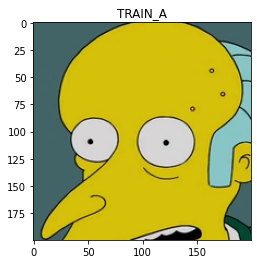

9975 imgs in TRAIN_B directory


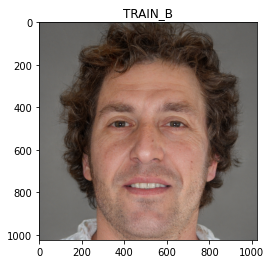

In [ ]:
def plot_from_image_path(path, title):
  """
  Verify by visual inspection that images are in correct directory. Images are aligned.

  Args:
    path:  str -> dataset to show
    title: str -> title label as legend
  """
  all_imgs = glob.glob(str(path/'*.*g')) # Read all images of that path

  print(f'{len(all_imgs)} imgs in {title} directory')

  img_path = random.choice(all_imgs)
  img = PIL.Image.open(img_path)
  plt.imshow(img)
  plt.title(title)
  plt.show()

plot_from_image_path(TRAIN_A, 'TRAIN_A')
plot_from_image_path(TRAIN_B, 'TRAIN_B')

### Training Setup and utilities functions

In [ ]:
one_epoch = ((LIMIT/100) * 50)/60 
EPOCHS = 200   # For how much you wanna run training
print(f'{EPOCHS} epochs would take {one_epoch*EPOCHS/60} hours')

200 epochs would take 277.7777777777777 hours


In [ ]:
import gc; gc.collect()
NAME = 'person2simpson' # Experiment name; in checkpoints model will be saved in this directory.
BATCH_SIZE = 2 # Reduce it to 1 if you get OOM error. Increase it if you have multiple GPUs.

In [ ]:
def copy_to_drive(folder = '/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/cyclegan_simpsonify'):
  """
  This methods copies your latest saved model from current environment to your provided path.
  In this case, I'm saving latest model in same environment but in another directory.
  You can even change and give it path to google drive folder by mounting it.

  Args:
    folder: str -> String of destination folder, where to store new latest model.
  """
  drive_folder = Path(folder)

  # To remove redundency, remove folder if it already exists.
  if(drive_folder.exists()):
    shutil.rmtree(drive_folder)

  # Copy latest model from checkpoints direcotry and save it in drive/provided path.
  shutil.copytree('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/', str(drive_folder))


def get_corresponding_photo(file_path):
  """
  Return corresponding photo. Name sync photo between Simpson and Human.

  Args:
    file_path: str -> Path to image who's corresponding is required.

  Returns:
    corresponding pair photo path by replacing fake with real, or real with fake
  """
  return file_path.replace('fake', 'real')


def plot_results(number):
  """
  Plot results. Read images generated at end of each epoch, and show them.

  Args:
    number: str -> number of images to display.
  """
  for i in range(number):
    # Show translated images
    img_path = random.choice(glob.glob('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/'+NAME+'/test_latest/images/*fake.*g'))
    print(img_path)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('fake')
    plt.show()

    # Show real images
    print(get_corresponding_photo(img_path))
    img = plt.imread(get_corresponding_photo(img_path))
    plt.imshow(img)
    plt.title('real')
    plt.show()


def get_model(src, dst):
  """
  Read latst  saved model in your drive, this will called when doing testing.
  Remove if previous model is present in provided destination

  Args:
    src: str -> source path from where to copy latest model file
    dst: str -> destination path from where to paste latest model
  """
  try:
    os.remove(dst)
  except:
    pass
  shutil.copyfile(src, dst)


def copy_from_drive(folder = '/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/cyclegan_simpsonify'):
  """"
  Read model from drive. Here as mentioned above, my models was being saved in same environment instead of
  google drive. So my drive path contain link for directory where my latest model is saved. 'cyclegan_simpsonify'
  If target checkpoints directory doesn't exists, make it first.
  Remove already data stored in target directory.

  Args:
    folder: str -> source of directory from where to copy model and paste in current environment.
  """
  drive_folder = Path(folder)

  # If target checkpoints directory doesn't exists, make it first.
  if(not Path('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/').exists()): 
    os.mkdir('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/')

  # Remove already data stored in target directory.
  if(Path('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/').exists()): 
    shutil.rmtree('/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

  # Copy model from source to destination - drive to current environment
  shutil.copytree(str(drive_folder), '/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')



def test_model (number_results = 5, direction = 'BtoA', src = None, dst = None):
  """
  This is where test cyclegan simpson face takes place.
  It loads your saved model.
  Saved model should generators should be named as latest_net_G_A.pth for BtoA or latest_net_G_B.pth for AtoB.

  Args:
    number_results: int -> how much number of images to generate
    direction: str
      BtoA: Human to simpson
      AtoB: Simpson to Human
    src: str -> Source to latest model file (drive)
    dst: str -> Destination to place latest model file (checkpoints directory in current environment)
  """

  # delete results if there is already some results generated there.
  if Path('./results').exists():
    shutil.rmtree('./results')
  os.mkdir('./results')

  # get appropriate model
  #
  if (src is None): src = './checkpoints/'+NAME+'/latest_net_G_'+direction.split('to')[-1]+'.pth'
  if (dst is None): dst = './checkpoints/'+NAME+'/latest_net_G.pth'
  get_model(src, dst)

  if (direction == 'BtoA'):
    test = TEST_B
  else:
    test = TEST_A
  
  # This is command line
  # test -> directory path where images are stored
  # NAME -> Experiment name, here in our case it is person2simpson
  cmd = 'python3 test.py --dataroot '+str(test)+' --name '+str(NAME)+' --model test --no_dropout'
  os.system(cmd)
  plot_results(number_results)


### CycleGAN Setup

Training parameters

In [ ]:
%cd /content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/
# Imports from CycleGAN repository
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer

""""
To see more detailed description of these parameters.
web link:   https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/master/options
local link: These file present in options directory in same environment.
Details for each argument is given in train_options.py, test_options.py and base_options.py
"""

opt = TrainOptions()  # TODO: TrainOptions().parse(**args) not working. Look into this.
opt.name = NAME
opt.dataroot = TRAIN_A.parent
opt.batch_size=BATCH_SIZE
opt.beta1=0.5
opt.checkpoints_dir='./checkpoints'
opt.continue_train=False  # if youe training crashed, or halts; you can resume it by turning it to True.
opt.crop_size=256
opt.dataset_mode='unaligned'
opt.direction='BtoA'
opt.display_env='main'
opt.display_freq=400
opt.display_id=1
opt.display_ncols=4
opt.display_port=8097
opt.display_server='http://localhost'
opt.display_winsize=256
opt.epoch='latest'
opt.epoch_count=52  # if opt.continue_train=True, change this parameter to where  training was stopped. Epoch
opt.gan_mode='lsgan'
opt.gpu_ids=[0] # -1 for CPU, 0 for 1 GPU, 0,1 for two GPU and so on.
opt.init_gain=0.02
opt.init_type='normal'
opt.input_nc=3
opt.isTrain=True
opt.lambda_A=10.0
opt.lambda_B=10.0
opt.lambda_identity=0.5
opt.load_iter=0
opt.load_size=286
opt.lr=2e-4
opt.lr_decay_iters=50
opt.lr_policy='linear'
opt.max_dataset_size=float("inf")
opt.n_epochs=EPOCHS
opt.model = 'cycle_gan'
opt.n_epochs_decay=EPOCHS//2
opt.n_layers_D=3
opt.name=NAME
opt.ndf=64
opt.netD='basic'
opt.netG='resnet_9blocks'
opt.ngf=64
opt.no_dropout=True
opt.no_flip=False
opt.no_html=False
opt.norm='instance' 
opt.num_threads=2
opt.output_nc=3
opt.phase='train'
opt.pool_size=50
opt.preprocess='resize_and_crop' 
opt.print_freq=100
opt.save_by_iter=False 
opt.save_epoch_freq=1
opt.save_latest_freq=5000
opt.serial_batches=False 
opt.suffix=''
opt.update_html_freq=1000
opt.verbose=False

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix


In [ ]:
# create dataset  by calling code given in repository Training Parameters.
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)

dataset [UnalignedDataset] was created
The number of training images = 9975


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
# Create model by calling code given in repository on Training Parameters.
model = create_model(opt)
model.setup(opt)
visualizer = Visualizer(opt)
total_iters = 0

Setting up a new session...


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
create web directory ./checkpoints/person2simpson/web...


In [ ]:
# Model's architecture
model.netG_A, model.netD_A 

(DataParallel(
   (module): ResnetGenerator(
     (model): Sequential(
       (0): ReflectionPad2d((3, 3, 3, 3))
       (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
       (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (3): ReLU(inplace=True)
       (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (6): ReLU(inplace=True)
       (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (9): ReLU(inplace=True)
       (10): ResnetBlock(
         (conv_block): Sequential(
           (0): ReflectionPad2d((1, 1, 1, 1))
           (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
           (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    

### Traning Loop

learning rate 0.0002000 -> 0.0002000


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(epoch: 52, iters: 100, time: 0.397, data: 0.388) D_A: 0.346 G_A: 0.389 cycle_A: 2.866 idt_A: 1.385 D_B: 0.293 G_B: 0.374 cycle_B: 3.192 idt_B: 1.344 
(epoch: 52, iters: 200, time: 0.397, data: 0.000) D_A: 0.284 G_A: 0.331 cycle_A: 2.129 idt_A: 0.947 D_B: 0.266 G_B: 0.299 cycle_B: 1.978 idt_B: 0.949 
(epoch: 52, iters: 300, time: 0.398, data: 0.000) D_A: 0.219 G_A: 0.263 cycle_A: 2.088 idt_A: 0.660 D_B: 0.270 G_B: 0.526 cycle_B: 1.609 idt_B: 0.901 
(epoch: 52, iters: 400, time: 0.708, data: 0.000) D_A: 0.313 G_A: 0.365 cycle_A: 2.005 idt_A: 1.367 D_B: 0.310 G_B: 0.391 cycle_B: 3.185 idt_B: 0.825 
(epoch: 52, iters: 500, time: 0.399, data: 0.000) D_A: 0.250 G_A: 0.425 cycle_A: 1.915 idt_A: 0.770 D_B: 0.170 G_B: 0.472 cycle_B: 1.806 idt_B: 0.930 
(epoch: 52, iters: 600, time: 0.397, data: 0.000) D_A: 0.217 G_A: 0.263 cycle_A: 1.618 idt_A: 1.133 D_B: 0.289 G_B: 0.245 cycle_B: 2.682 idt_B: 0.685 
(epoch: 52, iters: 700, time: 0.397, data: 0.000) D_A: 0.224 G_A: 0.539 cycle_A: 1.983 idt_A: 

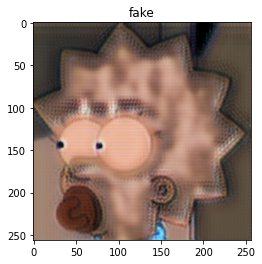

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/7447_real.png


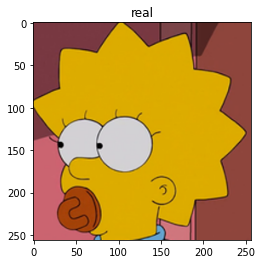

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_2444_fake.png


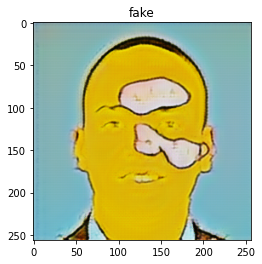

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_2444_real.png


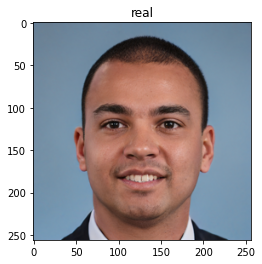





End of epoch 52 / 300 	 Time Taken: 3780 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 53, iters: 24, time: 0.776, data: 0.000) D_A: 0.147 G_A: 0.255 cycle_A: 0.939 idt_A: 0.405 D_B: 0.180 G_B: 0.408 cycle_B: 0.992 idt_B: 0.343 
saving the latest model (epoch 53, total_iters 10000)
(epoch: 53, iters: 124, time: 0.399, data: 0.000) D_A: 0.211 G_A: 0.677 cycle_A: 0.969 idt_A: 0.244 D_B: 0.156 G_B: 0.436 cycle_B: 0.642 idt_B: 0.468 
(epoch: 53, iters: 224, time: 0.399, data: 0.000) D_A: 0.106 G_A: 0.598 cycle_A: 1.164 idt_A: 0.351 D_B: 0.159 G_B: 0.260 cycle_B: 0.870 idt_B: 0.543 
(epoch: 53, iters: 324, time: 0.398, data: 0.000) D_A: 0.164 G_A: 0.290 cycle_A: 1.106 idt_A: 0.303 D_B: 0.166 G_B: 0.415 cycle_B: 0.743 idt_B: 0.456 
(epoch: 53, iters: 424, time: 0.503, data: 0.000) D_A: 0.087 G_A: 0.652 cycle_A: 1.085 idt_A: 0.349 D_B: 0.150 G_B: 0.315 cycle_B: 0.990 idt_B: 0.485 
(epoch: 53, iters: 524, time: 0.400, data: 0.000) D_A: 0.177 G_A: 0.596 cycle_A: 1.080 idt_A: 0.433 D_B: 0

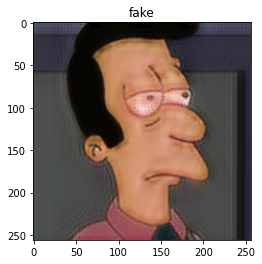

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/5292_real.png


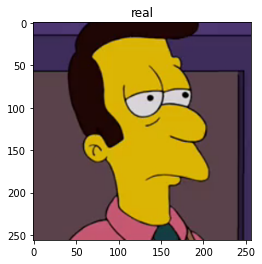

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_113_fake.png


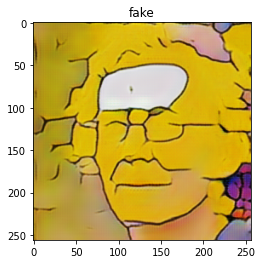

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_113_real.png


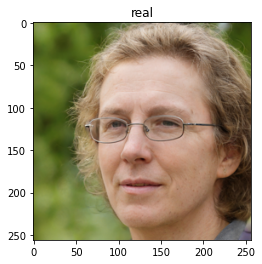





End of epoch 53 / 300 	 Time Taken: 3802 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 54, iters: 48, time: 0.855, data: 0.000) D_A: 0.151 G_A: 0.366 cycle_A: 1.114 idt_A: 0.272 D_B: 0.277 G_B: 0.198 cycle_B: 0.715 idt_B: 0.379 
saving the latest model (epoch 54, total_iters 20000)
(epoch: 54, iters: 148, time: 0.399, data: 0.000) D_A: 0.175 G_A: 0.464 cycle_A: 1.296 idt_A: 0.278 D_B: 0.220 G_B: 0.209 cycle_B: 0.931 idt_B: 0.475 
(epoch: 54, iters: 248, time: 0.400, data: 0.000) D_A: 0.384 G_A: 1.169 cycle_A: 1.289 idt_A: 0.451 D_B: 0.218 G_B: 0.267 cycle_B: 1.133 idt_B: 0.404 
(epoch: 54, iters: 348, time: 0.401, data: 0.000) D_A: 0.336 G_A: 0.910 cycle_A: 0.882 idt_A: 0.250 D_B: 0.259 G_B: 0.264 cycle_B: 0.672 idt_B: 0.391 
(epoch: 54, iters: 448, time: 0.521, data: 0.000) D_A: 0.155 G_A: 0.578 cycle_A: 1.002 idt_A: 0.384 D_B: 0.254 G_B: 0.351 cycle_B: 0.942 idt_B: 0.298 
(epoch: 54, iters: 548, time: 0.400, data: 0.000) D_A: 0.267 G_A: 0.606 cycle_A: 1.726 idt_A: 0.223 D_B: 0

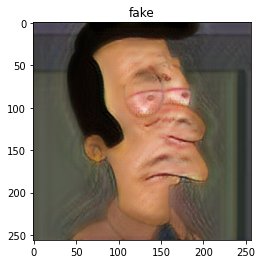

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/5292_real.png


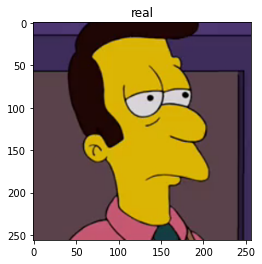

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_7379_fake.png


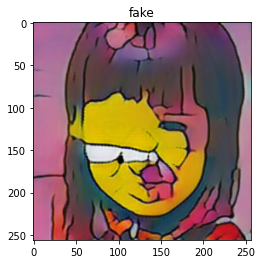

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_7379_real.png


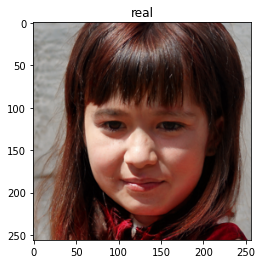





End of epoch 54 / 300 	 Time Taken: 3803 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 55, iters: 72, time: 0.836, data: 0.000) D_A: 0.194 G_A: 0.704 cycle_A: 0.942 idt_A: 0.288 D_B: 0.164 G_B: 0.491 cycle_B: 0.891 idt_B: 0.329 
saving the latest model (epoch 55, total_iters 30000)
(epoch: 55, iters: 172, time: 0.403, data: 0.000) D_A: 0.064 G_A: 0.651 cycle_A: 1.016 idt_A: 0.250 D_B: 0.175 G_B: 0.606 cycle_B: 0.753 idt_B: 0.436 
(epoch: 55, iters: 272, time: 0.400, data: 0.000) D_A: 0.096 G_A: 0.392 cycle_A: 1.359 idt_A: 0.345 D_B: 0.159 G_B: 0.507 cycle_B: 1.034 idt_B: 0.592 
(epoch: 55, iters: 372, time: 0.399, data: 0.000) D_A: 0.116 G_A: 0.442 cycle_A: 0.960 idt_A: 0.322 D_B: 0.107 G_B: 0.475 cycle_B: 0.872 idt_B: 0.322 
(epoch: 55, iters: 472, time: 0.529, data: 0.000) D_A: 0.084 G_A: 0.596 cycle_A: 1.251 idt_A: 0.398 D_B: 0.176 G_B: 0.188 cycle_B: 1.219 idt_B: 0.513 
(epoch: 55, iters: 572, time: 0.400, data: 0.000) D_A: 0.158 G_A: 1.321 cycle_A: 1.283 idt_A: 0.274 D_B: 0

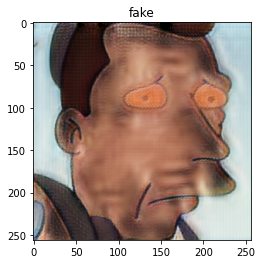

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/1283_real.png


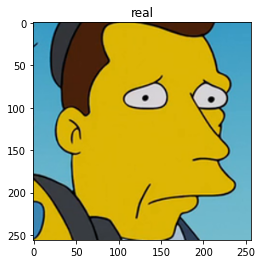

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_9136_fake.png


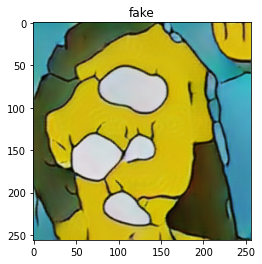

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_9136_real.png


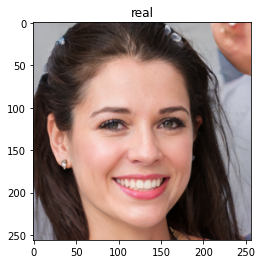





End of epoch 55 / 300 	 Time Taken: 3806 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 56, iters: 96, time: 0.839, data: 0.000) D_A: 0.126 G_A: 0.213 cycle_A: 0.915 idt_A: 0.218 D_B: 0.225 G_B: 0.317 cycle_B: 0.647 idt_B: 0.267 
saving the latest model (epoch 56, total_iters 40000)
(epoch: 56, iters: 196, time: 0.399, data: 0.000) D_A: 0.264 G_A: 0.716 cycle_A: 1.639 idt_A: 0.275 D_B: 0.211 G_B: 0.237 cycle_B: 0.766 idt_B: 0.329 
(epoch: 56, iters: 296, time: 0.400, data: 0.000) D_A: 0.155 G_A: 0.699 cycle_A: 1.027 idt_A: 0.229 D_B: 0.248 G_B: 0.290 cycle_B: 0.586 idt_B: 0.510 
(epoch: 56, iters: 396, time: 0.399, data: 0.001) D_A: 0.089 G_A: 0.201 cycle_A: 1.399 idt_A: 0.290 D_B: 0.236 G_B: 0.259 cycle_B: 0.762 idt_B: 0.530 
(epoch: 56, iters: 496, time: 0.529, data: 0.000) D_A: 0.060 G_A: 0.508 cycle_A: 0.763 idt_A: 0.279 D_B: 0.188 G_B: 0.277 cycle_B: 0.657 idt_B: 0.282 
(epoch: 56, iters: 596, time: 0.400, data: 0.000) D_A: 0.149 G_A: 0.266 cycle_A: 0.931 idt_A: 0.190 D_B: 0

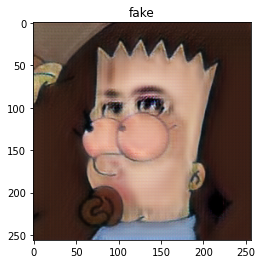

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/3930_real.png


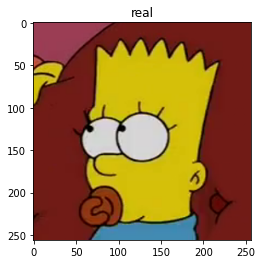

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_3188_fake.png


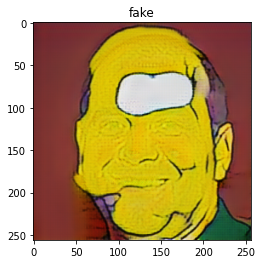

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_3188_real.png


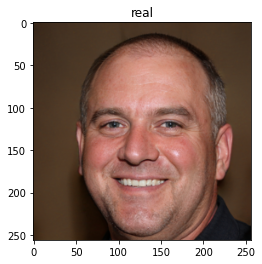





End of epoch 56 / 300 	 Time Taken: 3806 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 57, iters: 20, time: 0.400, data: 0.000) D_A: 0.214 G_A: 0.272 cycle_A: 0.742 idt_A: 0.182 D_B: 0.263 G_B: 0.301 cycle_B: 0.474 idt_B: 0.279 
(epoch: 57, iters: 120, time: 0.831, data: 0.000) D_A: 0.131 G_A: 0.355 cycle_A: 0.921 idt_A: 0.246 D_B: 0.265 G_B: 0.304 cycle_B: 0.664 idt_B: 0.336 
saving the latest model (epoch 57, total_iters 50000)
(epoch: 57, iters: 220, time: 0.400, data: 0.000) D_A: 0.231 G_A: 0.327 cycle_A: 0.705 idt_A: 0.252 D_B: 0.230 G_B: 0.306 cycle_B: 0.779 idt_B: 0.222 
(epoch: 57, iters: 320, time: 0.400, data: 0.000) D_A: 0.186 G_A: 0.393 cycle_A: 0.805 idt_A: 0.281 D_B: 0.253 G_B: 0.269 cycle_B: 0.742 idt_B: 0.307 
(epoch: 57, iters: 420, time: 0.400, data: 0.000) D_A: 0.219 G_A: 0.309 cycle_A: 0.832 idt_A: 0.202 D_B: 0.219 G_B: 0.343 cycle_B: 0.557 idt_B: 0.297 
(epoch: 57, iters: 520, time: 0.523, data: 0.000) D_A: 0.122 G_A: 0.336 cycle_A: 0.903 idt_A: 0.233 D_B: 0

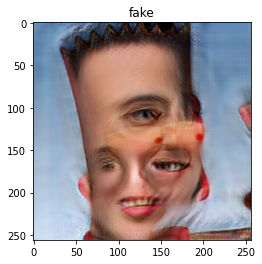

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/3861_real.png


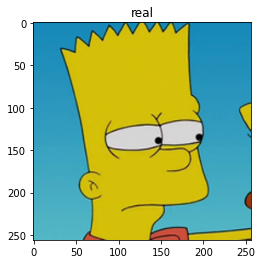

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_5473_fake.png


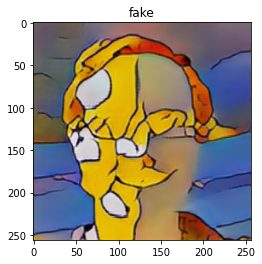

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_5473_real.png


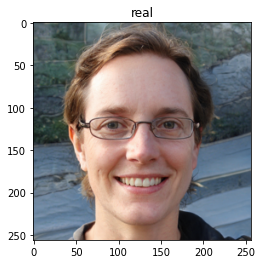





End of epoch 57 / 300 	 Time Taken: 3809 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 58, iters: 44, time: 0.399, data: 0.000) D_A: 0.235 G_A: 0.987 cycle_A: 1.261 idt_A: 0.374 D_B: 0.061 G_B: 0.537 cycle_B: 0.924 idt_B: 0.339 
(epoch: 58, iters: 144, time: 0.851, data: 0.000) D_A: 0.121 G_A: 0.616 cycle_A: 0.948 idt_A: 0.527 D_B: 0.116 G_B: 0.629 cycle_B: 0.800 idt_B: 0.333 
saving the latest model (epoch 58, total_iters 60000)
(epoch: 58, iters: 244, time: 0.398, data: 0.000) D_A: 0.054 G_A: 0.565 cycle_A: 0.781 idt_A: 0.263 D_B: 0.126 G_B: 0.557 cycle_B: 0.745 idt_B: 0.400 
(epoch: 58, iters: 344, time: 0.400, data: 0.000) D_A: 0.146 G_A: 0.533 cycle_A: 0.888 idt_A: 0.223 D_B: 0.247 G_B: 0.492 cycle_B: 0.743 idt_B: 0.420 
(epoch: 58, iters: 444, time: 0.400, data: 0.000) D_A: 0.038 G_A: 0.680 cycle_A: 0.871 idt_A: 0.196 D_B: 0.106 G_B: 0.599 cycle_B: 0.568 idt_B: 0.278 
(epoch: 58, iters: 544, time: 0.530, data: 0.000) D_A: 0.230 G_A: 0.846 cycle_A: 0.871 idt_A: 0.340 D_B: 0

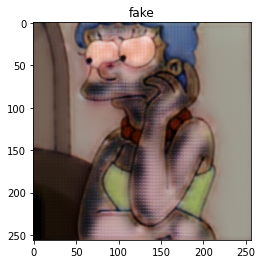

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/5179_real.png


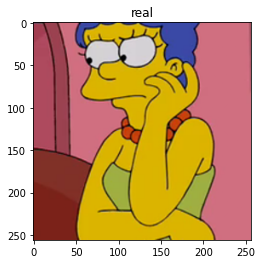

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_4159_fake.png


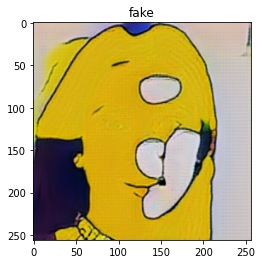

/content/SimpsonsFaces/pytorch-CycleGAN-and-pix2pix/results/person2simpson/test_latest/images/real_face_4159_real.png


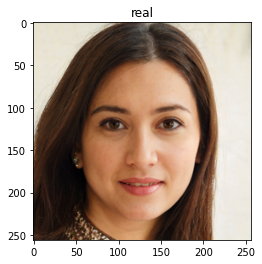





End of epoch 58 / 300 	 Time Taken: 3809 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 59, iters: 68, time: 0.401, data: 0.000) D_A: 0.073 G_A: 0.592 cycle_A: 1.123 idt_A: 0.238 D_B: 0.269 G_B: 0.264 cycle_B: 0.584 idt_B: 0.428 
(epoch: 59, iters: 168, time: 0.815, data: 0.000) D_A: 0.196 G_A: 0.245 cycle_A: 1.317 idt_A: 0.220 D_B: 0.256 G_B: 0.177 cycle_B: 0.588 idt_B: 0.477 
saving the latest model (epoch 59, total_iters 70000)
(epoch: 59, iters: 268, time: 0.399, data: 0.000) D_A: 0.099 G_A: 0.602 cycle_A: 0.797 idt_A: 0.192 D_B: 0.262 G_B: 0.240 cycle_B: 0.483 idt_B: 0.324 
(epoch: 59, iters: 368, time: 0.400, data: 0.000) D_A: 0.069 G_A: 0.389 cycle_A: 0.714 idt_A: 0.272 D_B: 0.280 G_B: 0.289 cycle_B: 0.638 idt_B: 0.306 
(epoch: 59, iters: 468, time: 0.400, data: 0.000) D_A: 0.045 G_A: 0.494 cycle_A: 0.942 idt_A: 0.266 D_B: 0.259 G_B: 0.325 cycle_B: 0.720 idt_B: 0.379 
(epoch: 59, iters: 568, time: 0.532, data: 0.000) D_A: 0.166 G_A: 0.485 cycle_A: 0.798 idt_A: 0.217 D_B: 0

In [ ]:
# adapted from: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/test.py
all_losses = []
opt.epoch_count = 52
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
    visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
    model.update_learning_rate()    # update learning rates in the beginning of every epoch.
    
    for i, data in enumerate(dataset):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration

        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            all_losses.append(losses)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()


    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
        copy_to_drive()
        test_model(1, 'AtoB')
        test_model(1, 'BtoA')

    print('\n\n\n\nEnd of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))


In [ ]:
test_model(1, 'AtoB')

In [ ]:
test_model(1, 'BtoA')